In [4]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:

time = "2024-06-10_12:52" # EUR_USD_M15
time = "2024-06-10_22:59" # USD_JPY_M15
time = "2024-06-11_04:01" # USD_CHF_M15
time = "2024-06-11_04:14" # USD_CAD_M15
time = "2024-06-11_11:42" # AUD_USD_M15
time = "2024-06-11_23:43" # AUD_JPY_M15
time = "2024-06-11_23:48" # AUD_CAD_M15
time = "2024-06-12_08:44" # EUR_JPY_M15
time = "2024-06-12_08:48" # GBP_CHF_M15
time = "2024-06-12_08:52" # GBP_JPY_M15

time = "2024-08-15_21:55" # EUR_CAD_M15
time = "2024-08-15_21:38" # NZD_USD_M15
time = "2024-08-15_21:36" # CAD_JPY_M15
time = "2024-08-15_21:34" # AUD_NZD_M15
time = "2024-08-15_21:33" # EUR_CHF_M15
time = "2024-08-15_21:31" # GBP_JPY_M15
time = "2024-08-15_21:27" # GBP_CHF_M15
time = "2024-08-15_21:25" # EUR_JPY_M15
time = "2024-08-15_21:23" # EUR_GBP_M15 
time = "2024-08-15_21:22" # AUD_CAD_M15
time = "2024-08-15_21:19" # AUD_USD_M15
time = "2024-08-15_21:18" # USD_CAD_M15
time = "2024-08-15_21:15" # AUD_JPY_M15
time = "2024-08-15_21:13" # USD_CHF_M15
time = "2024-08-15_21:11" # USD_JPY_M15
time = "2024-08-15_21:08" # GBP_USD_M15 
time = "2024-08-15_21:03" # EUR_USD_M15


df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")
df = df[(df["test_sharpe_ratio"] >= 0.2) | (df["test_inverse_sharpe_ratio"] >= 0.2)]

# """
df = df[(df["clustering_algorithm"] == 'gaussian_mixture')]
df = df[(df["num_clusters"] == 90)]
df = df[(df["random_seed"] == 50)]
df = df[(df["train_period"] == 9)]
df = df[(df["num_perceptually_important_points"] == 5)]
# """
df

,window,train_total_annualized_return,train_total_actual_return,train_total_trades,test_total_annualized_return,test_total_actual_return,test_total_trades,train_cumulative_actual_return,train_sharpe_ratio,test_cumulative_actual_return,test_sharpe_ratio,test_inverse_sharpe_ratio,max_cluster_labels,num_clusters,clustering_algorithm,train_period,test_period,random_seed,instrument,num_perceptually_important_points
486853,1,0.48,48.0,78,0.03,3.0,11,48.0,3.83501,3.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5
486854,2,0.38,38.0,72,0.15,15.0,23,86.0,3.83501,18.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5
486855,3,0.38,38.0,84,0.04,4.0,14,124.0,3.83501,22.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5
486856,4,0.41,41.0,150,-0.15,-15.0,17,165.0,3.83501,7.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5
486857,5,0.40,40.0,69,-0.13,-13.0,13,205.0,3.83501,-6.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487015,163,0.38,38.0,59,-0.07,-7.0,7,7247.0,3.83501,-631.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5
487016,164,0.35,35.0,61,0.00,0.0,12,7282.0,3.83501,-631.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5
487017,165,0.40,40.0,62,-0.22,-22.0,22,7322.0,3.83501,-653.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5
487018,166,0.27,27.0,63,-0.12,-12.0,33,7349.0,3.83501,-665.0,-0.445351,0.268271,1,90,gaussian_mixture,9,2,50,EUR_USD_M15,5


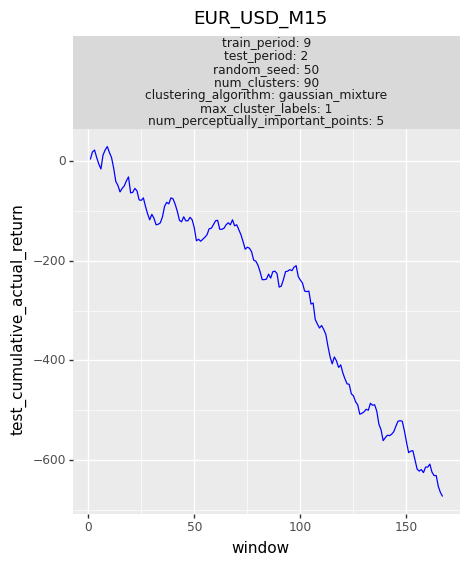

In [12]:
p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels + num_perceptually_important_points", scales="free_x", labeller="label_both")
p = p + theme(figure_size=(5, 5))
# p = p + theme(figure_size=(35, 35))
instrument = df['instrument'].iloc[0]
algo = df['clustering_algorithm'].iloc[0]
p = p + ggtitle(instrument)
print(p)

In [13]:
output_path = f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/strategy_figures/{instrument}_{algo}.png"
# save the df
df.to_csv(output_path.replace(".png", ".csv"), index=False)
p.save(output_path, dpi=300)

/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/strategy_figures/EUR_USD_M15_gaussian_mixture.png


## Analyzing Trading Strategies

In [ ]:
data_dict = {
    "train_period": [6, 6, 18],
    "random_seed": [10, 21, 4],
    "num_clusters": [120, 70, 90],
    "clustering_algorithm":  ["kmeans"] + 2 * ["gaussian_mixture"],
    "max_cluster_labels": 3 * [5],
}
params_concat_df = pd.DataFrame(data_dict)

# remove last row from the dataframe
# params_concat_df = params_concat_df.iloc[:-2]

# loop through the rows of the dataframe
# filter the original dataframe based on the row values
# plot the results
for index, row in params_concat_df.iterrows():
    train_period = row["train_period"]
    random_seed = row["random_seed"]
    num_clusters = row["num_clusters"]
    clustering_algorithm = row["clustering_algorithm"]
    max_cluster_labels = row["max_cluster_labels"]

    filtered_df = df[
        (df["train_period"] == train_period)
        & (df["random_seed"] == random_seed)
        & (df["num_clusters"] == num_clusters)
        & (df["clustering_algorithm"] == clustering_algorithm)
        & (df["max_cluster_labels"] == max_cluster_labels)
    ]
    sub_filtered_df = filtered_df[['window', 'test_total_actual_return', 'test_total_trades']]
    print(f"Strategy : {index + 1}")
    
    p = ggplot(filtered_df)
    p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
    p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels", scales="free_x", labeller="label_both")
    p = p + theme(figure_size=(5, 5))
    print(p)

## Monte Carlo Simulation

In [ ]:

def create_monte_carlo_variations(df, num_simulations=100):
    np.random.seed(42)
    
    results = []
    for _ in range(num_simulations):
        df_copy = df.copy()
        permuted_indices = np.random.permutation(len(df_copy))
        df_copy = df_copy.iloc[permuted_indices].reset_index(drop=True)
        results.append(df_copy)
    return results

def prepare_monte_carlo_data(monte_carlo_dfs, num_to_plot=100):
    prepared_dfs = []
    for i, df in enumerate(monte_carlo_dfs[:num_to_plot]):
        df_copy = df.copy()
        df_copy['cum_test_total_actual_return'] = df_copy['test_total_actual_return'].cumsum()
        df_copy['simulation'] = f'Sim {i+1}'
        df_copy['index'] = np.arange(len(df_copy))
        prepared_dfs.append(df_copy)
    
    return pd.concat(prepared_dfs, ignore_index=True)

def plot_monte_carlo_simulations(data):
    plot = (
        ggplot(data, aes(x='index', y='cum_test_total_actual_return', color='simulation')) +
        geom_line() +
        facet_wrap('~ simulation', scales='free_y', ncol=4) +
        labs(
            title='Cumulative Total Actual Return for Monte Carlo Simulations',
            x='Time Step',
            y='Cumulative Total Actual Return'
        ) +
        theme_minimal() +
        theme(
            figure_size=(16, 26),
            legend_position='none',
            axis_text_x=element_text(rotation=45, hjust=1)
        )
    )
    return plot

def plot_simulation_correlation_heatmap(monte_carlo_dfs, num_simulations=100):
    # Extract cumulative returns for each simulation
    cum_returns = []
    for df in monte_carlo_dfs[:num_simulations]:
        cum_returns.append(df['test_total_actual_return'].cumsum())
    
    # Create a DataFrame where each column is a simulation
    corr_data = pd.DataFrame(cum_returns).T
    corr_data.columns = [f'Sim {i+1}' for i in range(num_simulations)]
    
    # Compute the correlation matrix
    corr_matrix = corr_data.corr()
    
    # Create a heatmap using seaborn
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Monte Carlo Simulations')
    plt.tight_layout()
    
    # Instead of showing the plot, we'll save it to a file
    # plt.savefig('simulation_correlation_heatmap.png', dpi=300)
    # show the plot
    plt.show()
    plt.close()
    
    print("Simulation correlation heatmap has been saved as 'simulation_correlation_heatmap.png'")

# Usage example:
# Assuming sub_filtered_df is your original DataFrame
monte_carlo_dfs = create_monte_carlo_variations(sub_filtered_df, num_simulations=100)
data = prepare_monte_carlo_data(monte_carlo_dfs, 28*2)

# Verify that all simulations end with the same cumulative return
final_returns = data.groupby('simulation')['cum_test_total_actual_return'].last()
print("All final returns are the same:", final_returns.nunique() == 1)
print("Final return value:", final_returns.iloc[0])

# Generate and save the Monte Carlo simulation plot
plot = plot_monte_carlo_simulations(data)
print(plot)

# Generate and save the simulation correlation heatmap
plot_simulation_correlation_heatmap(monte_carlo_dfs, num_simulations=10)

In [ ]:
# Assuming filtered_df is your original dataframe
# Create a copy of the dataframe to ensure we're not working on a slice
sub_filtered_df = filtered_df[['window', 'test_total_actual_return', 'test_total_trades']].copy()

# remove rows with odd window values
sub_filtered_df = sub_filtered_df[sub_filtered_df['window'] % 2 != 0]

# Create 'month' and 'year' columns
sub_filtered_df['month'] = (sub_filtered_df['window'] - 1) // 2 + 1
sub_filtered_df['year'] = (sub_filtered_df['month'] - 1) // 12 + 1

# Calculate monthly totals and percentages
monthly_totals = sub_filtered_df.groupby('month').agg({
    'test_total_actual_return': 'sum',
    'test_total_trades': 'sum'
}).reset_index()
monthly_totals['monthly_return_percentage'] = monthly_totals['test_total_actual_return'] / monthly_totals['test_total_trades'] * 100

# Calculate yearly totals and percentages
yearly_totals = sub_filtered_df.groupby('year').agg({
    'test_total_actual_return': 'sum',
    'test_total_trades': 'sum'
}).reset_index()
yearly_totals['yearly_return_percentage'] = yearly_totals['test_total_actual_return'] / yearly_totals['test_total_trades'] * 100

# Merge monthly and yearly percentages back to the dataframe
sub_filtered_df = sub_filtered_df.merge(monthly_totals[['month', 'monthly_return_percentage']], on='month', how='left')
sub_filtered_df = sub_filtered_df.merge(yearly_totals[['year', 'yearly_return_percentage']], on='year', how='left')

In [ ]:
monthly_totals

In [ ]:
filtered_df

In [ ]:
R = 2.354
T = 17.1
win_rate = (0.5 * (T + R)) / T
win_rate